<a href="https://colab.research.google.com/github/chw8207/image_python/blob/main/%EA%B3%A0%EA%B8%89%ED%95%A9%EC%84%B1%EA%B3%B1%EC%8B%A0%EA%B2%BD%EB%A7%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Activation, MaxPool2D, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.utils import to_categorical
from keras.regularizers import l2
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import numpy as np

### GPU 설정

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0' :
    raise SystemError('GPU device not found')
print(f'Found GPU at: {device_name}')

Found GPU at: /device:GPU:0


In [3]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13129738385522828468
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8345915776468482576
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


### LeNet-5 구현

- 데이터

In [33]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("The MNIST database has a training set of %d examples." % len(X_train))
print("The MNIST database has a test set of %d examples." % len(X_test))

The MNIST database has a training set of 60000 examples.
The MNIST database has a test set of 10000 examples.


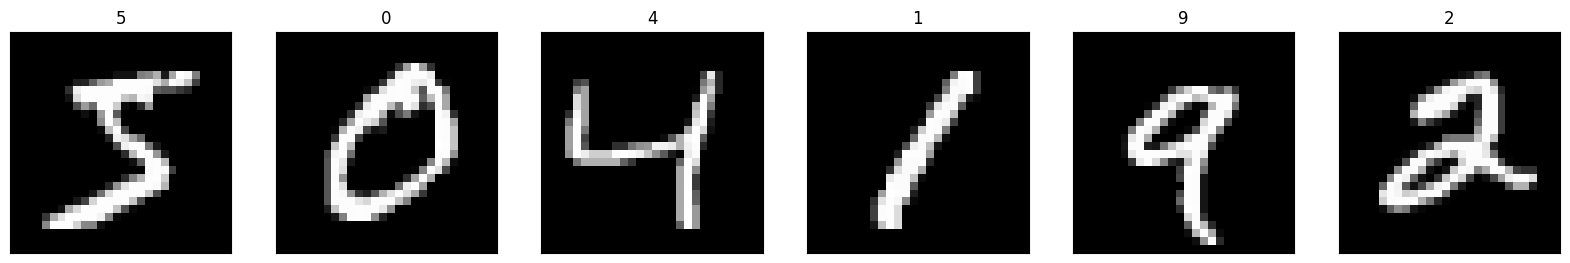

In [34]:
# plot first six training images
fig = plt.figure(figsize=(20,20))
for i in range(6):
    ax = fig.add_subplot(1, 6, i+1, xticks=[], yticks=[])
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(str(y_train[i]))

plt.show()

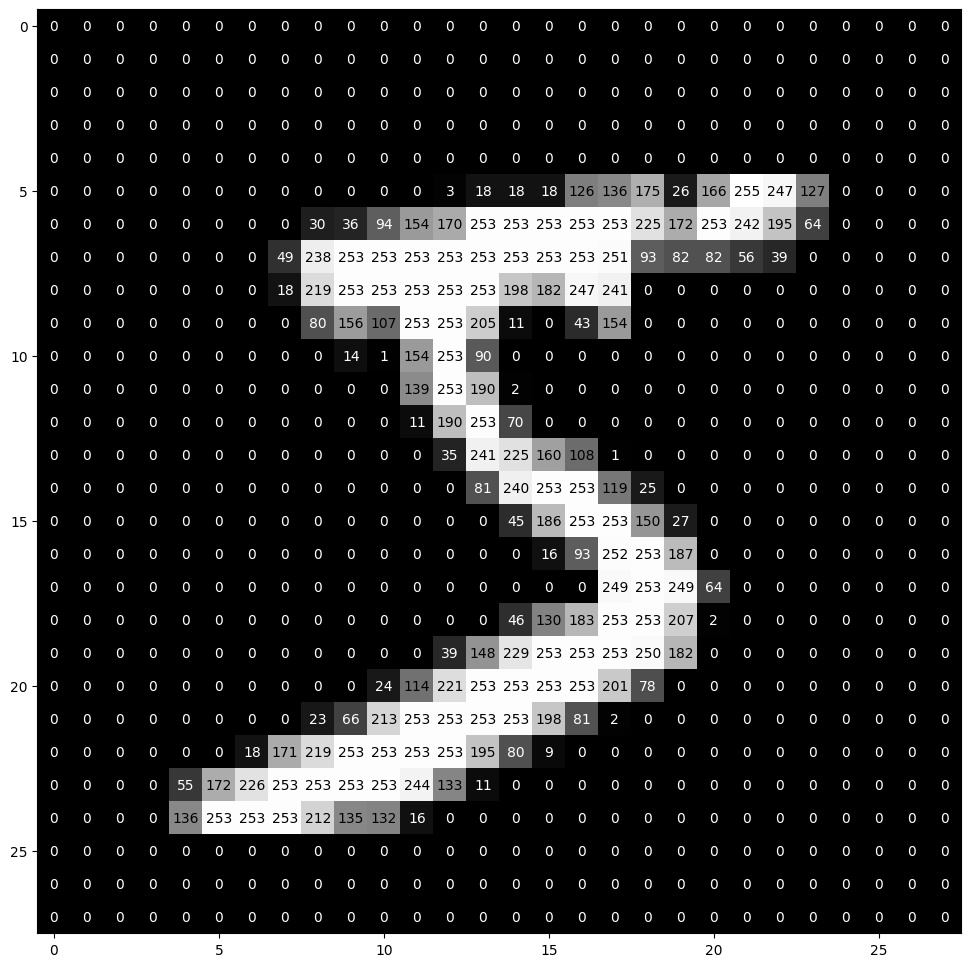

In [35]:
def visualize_input(img, ax):
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
visualize_input(X_train[0], ax)

- 이미지 전처리

In [36]:
mean = np.mean(X_train)
std = np.std(X_train)
X_train = (X_train-mean) / (std + 1e-7)
X_test = (X_test-mean) / (std + 1e-7)

In [37]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


- 레이블(원-핫 인코딩)

In [38]:
num_classes = 10

print('Integer-valued labels:', y_train[:10])

# 원-핫 인코딩
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print('One-hot labels:', y_train[:10])

Integer-valued labels: [5 0 4 1 9 2 1 3 1 4]
One-hot labels: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


- reshape

In [39]:
img_rows, img_cols = 28, 28

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols)

print('image input shape: ', input_shape)
print('x_train shape:', X_train.shape)

image input shape:  (28, 28)
x_train shape: (60000, 28, 28, 1)


In [40]:
model = Sequential()

# 합성곱층 C1
model.add(Conv2D(filters=6, kernel_size=5, strides=1, activation='tanh', input_shape=(28,28,1), padding='same'))

# 풀링층 S2
model.add(AveragePooling2D(pool_size=2, strides=2, padding='valid'))

# 합성곱층 C3
model.add(Conv2D(filters=16, kernel_size=5, strides=1, activation='tanh', padding='valid'))

# 풀링층 S4
model.add(AveragePooling2D(pool_size=2, strides=2, padding='valid'))

# 합성곱층 C5
model.add(Conv2D(filters=120, kernel_size=5, strides=1, activation='tanh', padding='valid'))

model.add(Flatten())

# 전결합층 FC6
model.add(Dense(units=84, activation='tanh'))

# 출력층 FC7
model.add(Dense(units=10, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_4 (Avera  (None, 14, 14, 6)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_5 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 conv2d_8 (Conv2D)           (None, 1, 1, 120)         48120     
                                                                 
 flatten_2 (Flatten)         (None, 120)              

- 하이퍼파라미터 설정

In [41]:
def lr_schedule(epoch) :
  if epoch <= 2 :
    lr = 5e-4
  elif epoch > 2 and epoch <= 5 :
    lr = 2e-4
  elif epoch > 5 and epoch <= 9 :
    lr = 5e-5
  else :
    lr = 1e-5
  return lr

In [56]:
lr_scheduler = LearningRateScheduler(lr_schedule)
checkpoint = ModelCheckpoint(filepath='model.weights.best.hdf5', monitor='val_accuracy',
                             verbose=1, save_best_only=True)

callbacks = [checkpoint, lr_scheduler]

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [57]:
hist = model.fit(X_train, y_train, batch_size=32, epochs=20,
          validation_data=(X_test, y_test), callbacks=callbacks,
          verbose=2, shuffle=True)

Epoch 1/20

Epoch 1: val_accuracy improved from -inf to 0.98820, saving model to model.weights.best.hdf5
1875/1875 - 8s - loss: 0.0291 - accuracy: 0.9906 - val_loss: 0.0365 - val_accuracy: 0.9882 - lr: 5.0000e-04 - 8s/epoch - 4ms/step
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy improved from 0.98820 to 0.98850, saving model to model.weights.best.hdf5
1875/1875 - 7s - loss: 0.0250 - accuracy: 0.9920 - val_loss: 0.0357 - val_accuracy: 0.9885 - lr: 5.0000e-04 - 7s/epoch - 4ms/step
Epoch 3/20

Epoch 3: val_accuracy improved from 0.98850 to 0.98860, saving model to model.weights.best.hdf5
1875/1875 - 6s - loss: 0.0212 - accuracy: 0.9930 - val_loss: 0.0349 - val_accuracy: 0.9886 - lr: 5.0000e-04 - 6s/epoch - 3ms/step
Epoch 4/20

Epoch 4: val_accuracy improved from 0.98860 to 0.98970, saving model to model.weights.best.hdf5
1875/1875 - 7s - loss: 0.0110 - accuracy: 0.9970 - val_loss: 0.0304 - val_accuracy: 0.9897 - lr: 2.0000e-04 - 7s/epoch - 4ms/step
Epoch 5/20

Epoch 5: val_accuracy did not improve from 0.98970
1875/1875 - 7s - loss: 0.0086 - accuracy: 0.9979 - val_loss: 0.0360 - val_accuracy: 0.9894 - lr: 2.0000e-04 - 7s/epoch - 4ms/step
Epoch 6/20

Epoch 6: val_accuracy improved from 0.98970 to 0.99060, saving model to model.weights.best.h

- Load the Model with the Best Classification Accuracy on the Validation Set

In [58]:
model.load_weights('model.weights.best.hdf5')

In [60]:
score = model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 99.1500%


- 시각화

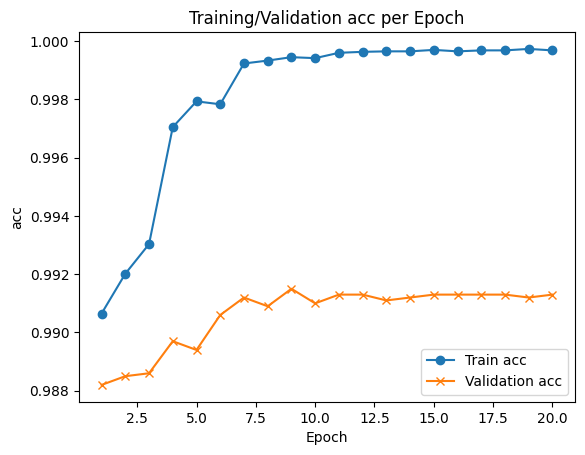

In [61]:
f, ax = plt.subplots()
ax.plot([None] + hist.history['accuracy'], 'o-')
ax.plot([None] + hist.history['val_accuracy'], 'x-')
# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train acc', 'Validation acc'], loc = 0)
ax.set_title('Training/Validation acc per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('acc')
plt.show()

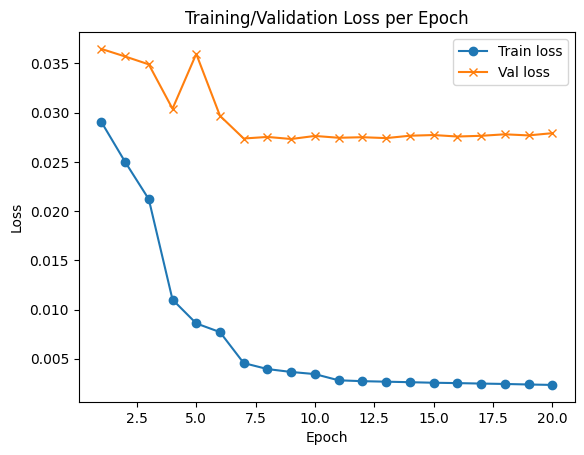

In [62]:
f, ax = plt.subplots()
ax.plot([None] + hist.history['loss'], 'o-')
ax.plot([None] + hist.history['val_loss'], 'x-')

# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train loss', "Val loss"], loc = 0)
ax.set_title('Training/Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.show()

### AlexNet

In [64]:
model = Sequential()

# 첫 번째 층(CONV + POOL + 배치 정규화)
model.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='valid', input_shape=(227,227,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
model.add(BatchNormalization())

# 두 번째 층(CONV + POOL + 배치 정규화)
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', kernel_regularizer=l2(0.0005)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'))
model.add(BatchNormalization())

# 세 번째 층(CONV + 배치 정규화)
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=l2(0.0005)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# 네 번째 층(CONV + 배치 정규화)
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=l2(0.0005)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# 다섯 번째 층(CONV + 배치 정규화)
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=l2(0.0005)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'))

model.add(Flatten())

# 여섯 번째 층 (FC + 드롭아웃)
model.add(Dense(units=4096, activation='relu'))
model.add(Dropout(0.5))

# 일곱 번째 층 (FC + 드롭아웃)
model.add(Dense(units=4096, activation='relu'))
model.add(Dropout(0.5))

# 여덟 번째 층 (FC(소프트맥스 함수))
model.add(Dense(units=1000, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 55, 55, 96)        34944     
                                                                 
 activation (Activation)     (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 27, 27, 96)        384       
 Normalization)                                                  
                                                                 
 conv2d_10 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 activation_1 (Activation)   (None, 27, 27, 256)      